# Coursera Capstone Project: Segmenting and Clustering Neighborhoods in Toronto

This notebook will be used specifically for completing the Applied Data Science capstone project in Coursera.

**Note: I used the same notebook for the entire course.**

**Note: I the magic command "%%capture" in some cells to remove the output and improve readability**

### Week 1 Assignment

In [89]:
%%capture

!pip install numpy==1.19.4
!pip install pandas
import pandas as pd
import numpy as np

In [3]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


### Week 3 Assignment (Part 1)

Installed and imported the necessary libraries.

In [98]:
%%capture

!pip install geopy
!pip install folium==0.5.0
!pip install beautifulsoup4
!pip install matplotlib
!pip install sklearn

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab

import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json # library to handle JSON files
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
from IPython.display import Image # libraries for displaying images
from IPython.core.display import HTML # libraries for displaying images
from IPython.display import display
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules
from sklearn.cluster import KMeans # import k-means from clustering stage
import folium # plotting library
import matplotlib.pyplot as plt 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

First I got the neighborhood data from wikipedia using Beautiful Soup and created a dataframe

In [7]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
result = requests.get(url)
data_html = BeautifulSoup(result.content)

soup = BeautifulSoup(str(data_html))

Then I scraped the data to obtain the Postal Code, Borough and Neighborhood.

In [25]:
content=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        content.append(cell)

df=pd.DataFrame(content)

Then I created a pandas dataframe using this data.

In [27]:
df=pd.DataFrame(content)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


Then I saved the dataframe into a csv file.

In [29]:
df.to_csv('neighborhood-df.csv')

Then I dropped any unnecesary data like nulls and cells that contain "Not Assigned" value. Used the shape function to print the number of rows in the dataframe.

In [41]:
df_dropna = df.dropna()
empty = 'Not assigned'
df_dropna = df_dropna[(df_dropna.PostalCode != empty ) & (df_dropna.Borough != empty) & (df_dropna.Neighborhood != empty)].reset_index(drop=True)
df = df_dropna
df.shape

(103, 5)

### Week 3 Assignment (Part 2)

Using a csv provided by cocl.us I obtained the geo-coordiantes for each Postal Code.

In [37]:
coords_url = "https://cocl.us/Geospatial_data"

coords_df = pd.read_csv(coords_url)
coords_df.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
coords_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Then I merged both dataframes to create a single dataframe with all the data.

In [39]:
df = pd.merge(df, coords_df, on='PostalCode')
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


### Week 3 Assignment (Part 3)

To explore the dataframe I first counted the number of neighborhoods by each different borough.

In [56]:
df_toronto = df
df.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto                                                  9
Downtown Toronto                                                17
Downtown TorontoStn A PO Boxes25 The Esplanade                   1
East Toronto                                                     4
East TorontoBusiness reply mail Processing Centre969 Eastern     1
East York                                                        4
East YorkEast Toronto                                            1
Etobicoke                                                       11
EtobicokeNorthwest                                               1
MississaugaCanada Post Gateway Processing Centre                 1
North York                                                      24
Queen's Park                                                     1
Scarborough                                                     17
West Toronto                                                     6
York                                                  

Then I decided to obtain the coordinates for Toronto using the mean values of every postal code. This will be used to create a Folium map.

In [59]:
boroughs = df_toronto['Borough'].unique().tolist()
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()

print("Toronto Coordinates:",lat_toronto,",",lon_toronto)

Toronto Coordinates: 43.704607733980595 , -79.39715291165048


Then I assigned each borough a random color.

In [62]:
borough_color = {}
for borough in boroughs:
    borough_color[borough]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3))

Finally, I created a Folium map to visualize the Toronto's boroughs. Used ipython magic folium library to display the map since Jupyter Notebook was having problem visualizing it.

In [130]:
%%capture

!pip install git+https://github.com/psychemedia/ipython_magic_folium.git
%load_ext folium_magic

In [131]:
toronto_map = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=9)

markers = []
for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], 
                                           df_toronto['Longitude'],
                                           df_toronto['Borough'], 
                                           df_toronto['Neighborhood']):
    label_text = borough + ' - ' + neighborhood
    label = folium.Popup(label_text)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=borough_color[borough],
        fill_color=borough_color[borough],
        fill_opacity=0.7).add_to(toronto_map)
    info = [lat,lng,borough+","+neighborhood]
    markers.append(info)
    
%folium_map -l 43.70460773398059,-79.39715291165048 -M markers

I stored my Foursquare credentials in variables.

In [92]:
%%capture

CLIENT_ID='YZ2VEXJYI1SNN4WG4PYNGGKUE223OTCES4XDL2IMXDF3MM5X'
CLIENT_SECRET='DSWPWQTCQFN4KXDMYRPQ5AFG1VR5LRSBFBZRSQATYMHWPIQL'
VERSION = 20200514

Then I created a function that sends a request to Foursquares venues endpoint using my credentials. I limited the number of venues to 100.

In [75]:
def getVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 100
    radius = 500
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

I used the function created above to obtain the nearby venues using the previously created dataframe. I hid the results with metadata to improve readability.

In [93]:
%%capture

nearby_venues = getVenues(names=df_toronto['Neighborhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

Here we can see the first 5 rows of the resulting dataframe.

In [134]:
nearby_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,KFC,43.754387,-79.333021,Fast Food Restaurant
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,TTC stop #8380,43.752672,-79.326351,Bus Stop
3,Parkwoods,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
4,Victoria Village,43.725882,-79.315572,Victoria Village Arena,43.723481,-79.315635,Hockey Arena


Lets try looking if there is Indian Restaurant nearby.

In [154]:
"Indian Restaurant" in nearby_venues['Venue Category'].unique()

True

In [155]:
to_onehot = pd.get_dummies(nearby_venues[['Venue Category']], prefix="", prefix_sep="")

to_onehot['Neighborhoods'] = nearby_venues['Neighborhood'] 

fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index() 

ita = to_grouped[["Neighborhoods","Indian Restaurant"]]
ita.head()

ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})
X = ita.drop(['Neighborhood'], axis=1)

Then I used the elbow method to find the k-mean.

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:1077: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (18). Possibly 

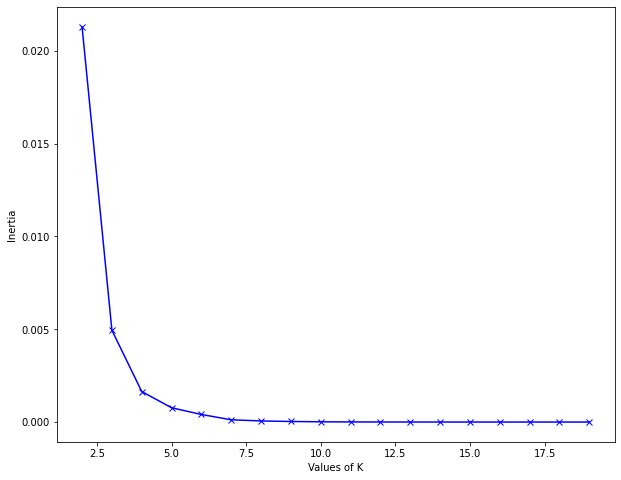

In [162]:
ita = ita.rename(columns={'Neighborhoods':'Neighborhood'})
X = ita.drop(['Neighborhood'], axis=1)
plt.figure(figsize=[10, 8])
inertia=[]
range_val=range(2,20)
for i in range_val:
  kmean=KMeans(n_clusters=i)
  kmean.fit_predict(X)
  inertia.append(kmean.inertia_)
plt.plot(range_val,inertia,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.show()

In [159]:
kclusters = 4
toronto_grouped_clustering = ita.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)
kmeans.labels_[0:10]
np.unique(kmeans.labels_)

array([0, 1, 2, 3], dtype=int32)

Finally, lets see how many neigborhoods are in each cluster.

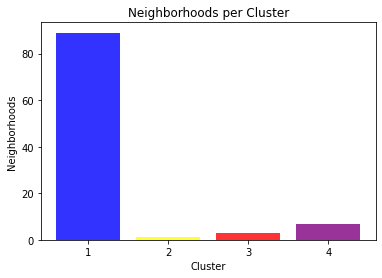

In [178]:
objects = (1,2,3,4)
y_pos = np.arange(len(objects))
performance = ita['Cluster Labels'].value_counts().to_frame().sort_index(ascending=True)
perf = performance['Cluster Labels'].tolist()
plt.bar(y_pos, perf, align='center', alpha=0.8, color=['blue', 'yellow','red', 'purple'])
plt.xticks(y_pos, objects)
plt.ylabel('Neighborhoods')
plt.xlabel('Cluster')
plt.title('Neighborhoods per Cluster')

plt.show()